In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, \
                                    Reshape, Conv2DTranspose, Dropout, \
                                    Embedding, Concatenate, Input
from tensorflow.keras.initializers import RandomNormal

from tensorflow.keras.optimizers import Adam

In [0]:
opt=Adam(lr=0.0002, beta_1=0.5)

In [0]:
def create_discriminator(in_shape=(28,28,1), n_classes=10):
    # input layer
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(merge)
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(fe)
    # Flatten feature maps
    fe = Flatten()(fe)  
    # Regularization via dropout
    fe = Dropout(0.4)(fe)
    # Output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # Creating model
    model = Model([in_image, in_label], out_layer)
    model. compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

    

In [0]:
def create_generator(latent_dim=100, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7*7
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128*7*7
    gen = Dense(n_nodes, activation=LeakyReLU(alpha=0.2))(in_lat)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsampling to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(merge)
    # updampling to 28x28
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(gen)
    # output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same'
                       )(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model


In [0]:
def create_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # get noise and label inputs from generator
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_output = generator.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def load_real_data(dataset):
    # Loading data
    (X_train, y_train), (X_test, y_test) = dataset.load_data()
    # We don't need separate test data so we can add it to our training data
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)
    # Conv2D awaits 3-dimensional input data (color channel) so, we must add 1 axis
    X_train = np.expand_dims(X_train, axis=-1)
    # Rescale our data from [0, 255] to [-1,1]
    X_train = X_train.astype('float32')
    X_train = (X_train - 127.5) / 127.5
    return [X_train, y_train]

In [0]:
def gen_real_batch(dataset, n_samples):
    X_train, y_train = dataset
    # Generate n random indexes
    ix = np.random.randint(0, X_train.shape[0], n_samples)
    # Select n random images from our imageset
    X = X_train[ix]
    labels = y_train[ix]
    y = np.ones(n_samples)
    return [X, labels], y

In [0]:
# Create n random latent-space vectors
def gen_latent_vecs(n_samples, latent_dim=100, n_classes=10):
    latent_vecs = np.random.normal(0, 1, [n_samples, latent_dim])
    labels = np.random.randint(0, n_classes, n_samples)
    return [latent_vecs, labels]

In [0]:
def gen_fake_batch(generator, n_samples, latent_dim=100, n_classes=10):
    [latent_vecs, labels] = gen_latent_vecs(n_samples, latent_dim, n_classes)
    X = generator.predict([latent_vecs, labels])
    y = np.zeros(n_samples)
    return [X, labels], y

In [0]:
def gen_train_batch(generator, dataset, batch_size, latent_dim=100, n_classes=10):
    half_batch_size = batch_size // 2
    # Get a half batch of real samples
    [X_real, real_labels], y_real = gen_real_batch(dataset, half_batch_size)
    # Get a half batch of fake samples
    [X_fake, fake_labels], y_fake = gen_fake_batch(generator, half_batch_size, \
                                                   latent_dim, n_classes)
    # Make a mixed batch
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    # Shuffle real and fake images
    shuffle = np.random.randint(0, batch_size, batch_size)
    X = X[shuffle]
    y = y[shuffle]
    labels = labels[shuffle]
    return [X, labels], y

In [0]:
def print_generated_images(generator, h, w, latent_dim=100):
    n = h*w
    X, _ = gen_latent_vecs(n, latent_dim)
    labels = np.asarray([x for _ in range(h) for x in range(w)])
    y_p = generator.predict([X, labels])

    fig = plt.figure(figsize=(20,10))
    for i in range(n):
        plt.subplot(h, w, 1 + i)
        plt.axis('off')
        plt.title("label: {}".format(labels[i]))
        plt.imshow(y_p[i, :, :, 0], cmap='gray_r')
    plt.show()

In [0]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epoches=100, \
          batch_size=128, n_classes=10):
    X_train, y_train = dataset
    n_batches = X_train.shape[0] // batch_size
    half_batch_size = batch_size // 2

    for i in range(n_epoches):
        for j in range(n_batches):
            # Train discriminator
            [X_d, labels_d], y_d = gen_train_batch(generator, dataset, \
                                                   batch_size, latent_dim)
            d_loss, d_acc = discriminator.train_on_batch([X_d, labels_d], y_d)
            # Train generator
            [X_gan, labels] = gen_latent_vecs(batch_size, latent_dim)
            y_gan = np.ones(batch_size)
            g_loss = gan.train_on_batch([X_gan, labels], y_gan)

            print('\r>%d, %d/%d, d_l=%.3f, d_a=%.3f g=%.3f' % (i+1, j+1, n_batches, d_loss, d_acc, g_loss), end='')
        print()
        if i == 0 or i == 1 or (i+1) % 20 == 0:
            print_generated_images(generator, 4, 10, latent_dim)

>1, 546/546, d_l=0.677, d_a=0.602 g=0.724


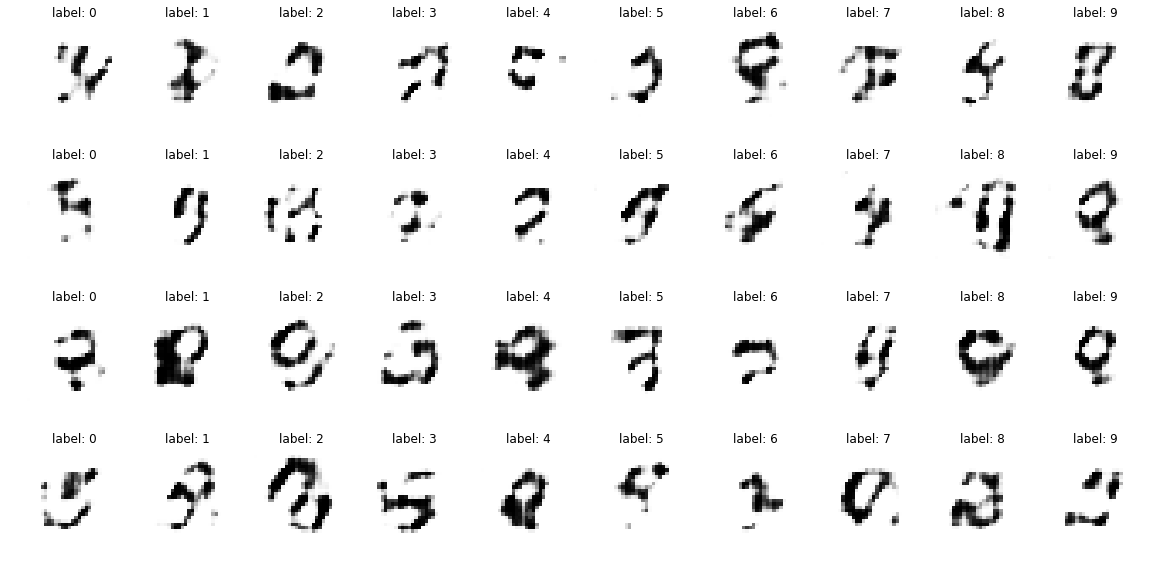

>2, 546/546, d_l=0.475, d_a=0.773 g=1.235


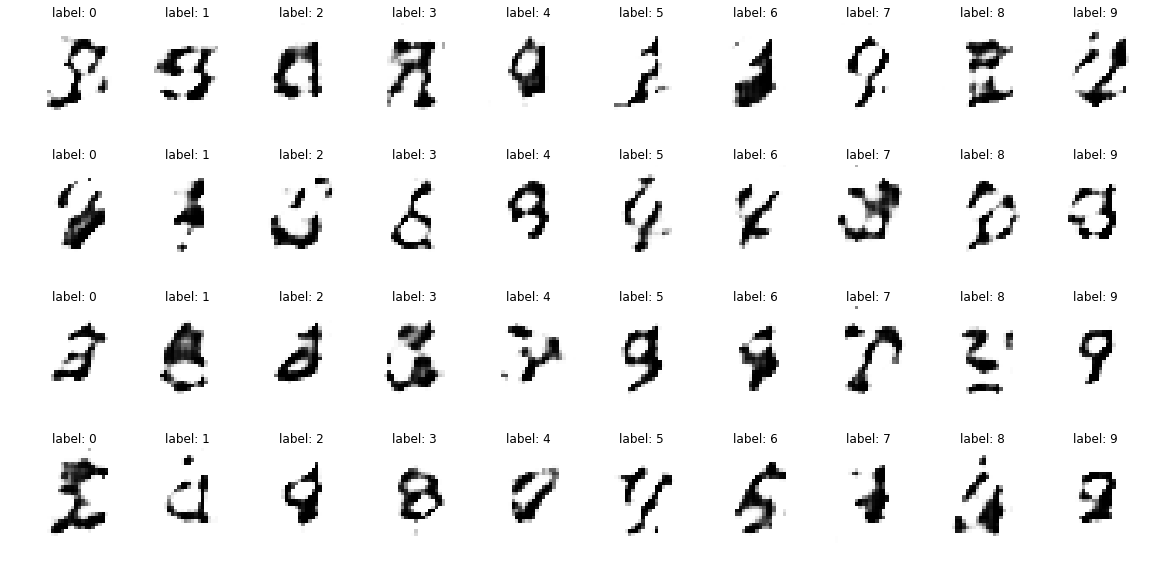

>3, 546/546, d_l=0.656, d_a=0.641 g=0.912
>4, 546/546, d_l=0.582, d_a=0.719 g=0.785
>5, 546/546, d_l=0.549, d_a=0.727 g=1.123
>6, 546/546, d_l=0.527, d_a=0.750 g=0.986
>7, 546/546, d_l=0.647, d_a=0.562 g=0.994
>8, 546/546, d_l=0.610, d_a=0.688 g=0.838
>9, 546/546, d_l=0.585, d_a=0.742 g=0.868
>10, 546/546, d_l=0.553, d_a=0.711 g=0.696


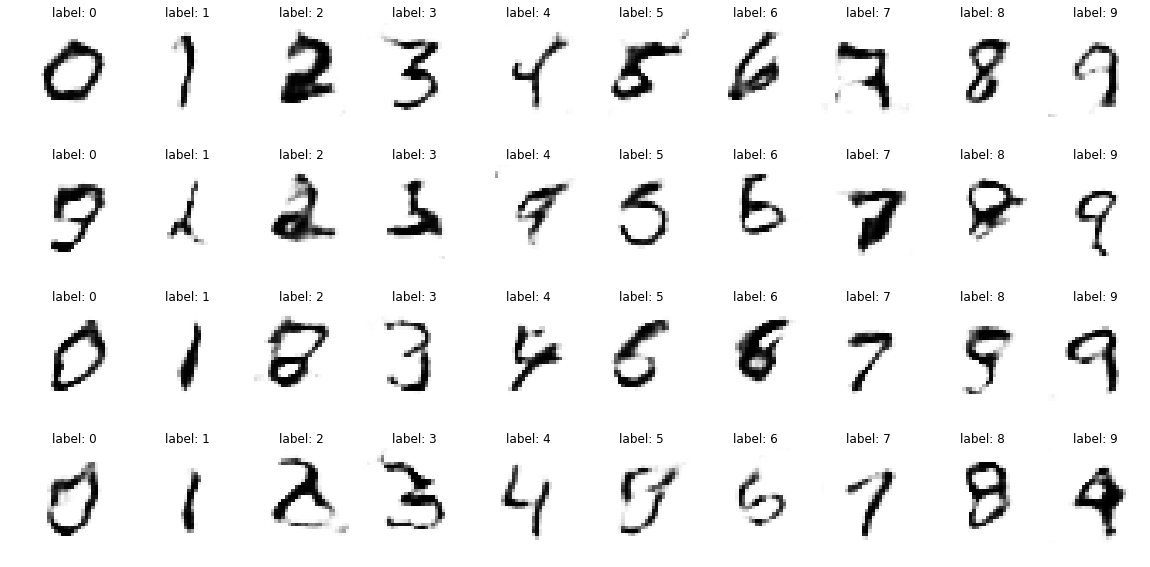

>11, 546/546, d_l=0.628, d_a=0.672 g=0.865
>12, 546/546, d_l=0.586, d_a=0.703 g=0.920
>13, 546/546, d_l=0.600, d_a=0.648 g=0.711
>14, 546/546, d_l=0.625, d_a=0.633 g=0.777
>15, 546/546, d_l=0.563, d_a=0.719 g=1.085
>16, 546/546, d_l=0.511, d_a=0.836 g=0.968
>17, 546/546, d_l=0.588, d_a=0.695 g=0.886
>18, 546/546, d_l=0.600, d_a=0.719 g=0.736
>19, 546/546, d_l=0.597, d_a=0.727 g=1.188
>20, 546/546, d_l=0.531, d_a=0.789 g=0.863


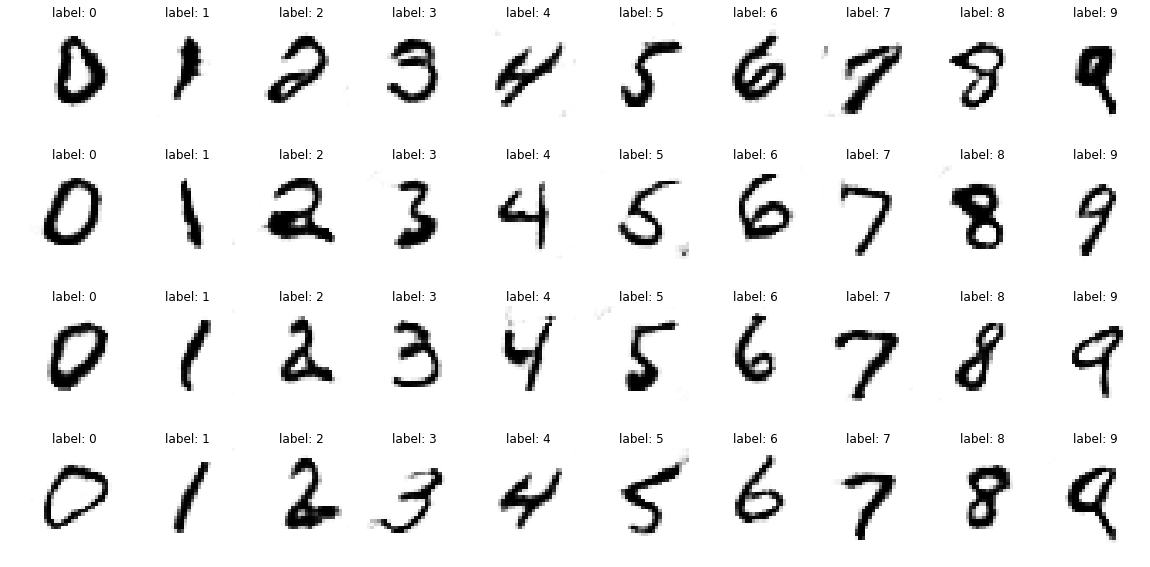

>21, 546/546, d_l=0.584, d_a=0.719 g=1.008
>22, 546/546, d_l=0.570, d_a=0.703 g=0.871
>23, 546/546, d_l=0.614, d_a=0.672 g=0.703
>24, 546/546, d_l=0.575, d_a=0.688 g=1.226
>25, 546/546, d_l=0.602, d_a=0.641 g=0.941
>26, 546/546, d_l=0.590, d_a=0.672 g=0.984
>27, 546/546, d_l=0.647, d_a=0.586 g=1.163
>28, 546/546, d_l=0.524, d_a=0.734 g=0.874
>29, 546/546, d_l=0.646, d_a=0.609 g=0.508
>30, 546/546, d_l=0.551, d_a=0.734 g=0.976


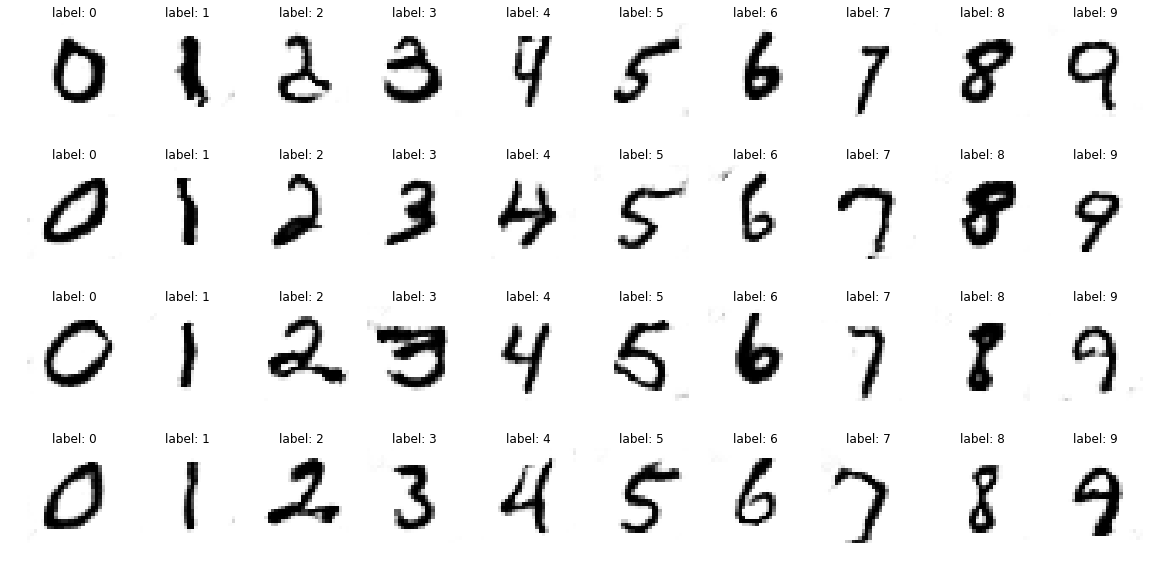

>31, 546/546, d_l=0.592, d_a=0.656 g=1.023
>32, 546/546, d_l=0.556, d_a=0.672 g=1.151
>33, 546/546, d_l=0.565, d_a=0.703 g=0.995
>34, 546/546, d_l=0.533, d_a=0.750 g=0.511
>35, 546/546, d_l=0.583, d_a=0.695 g=0.952
>36, 546/546, d_l=0.602, d_a=0.633 g=1.297
>37, 546/546, d_l=0.609, d_a=0.656 g=1.102
>38, 546/546, d_l=0.514, d_a=0.789 g=0.966
>39, 546/546, d_l=0.534, d_a=0.727 g=0.996
>40, 546/546, d_l=0.536, d_a=0.734 g=0.846


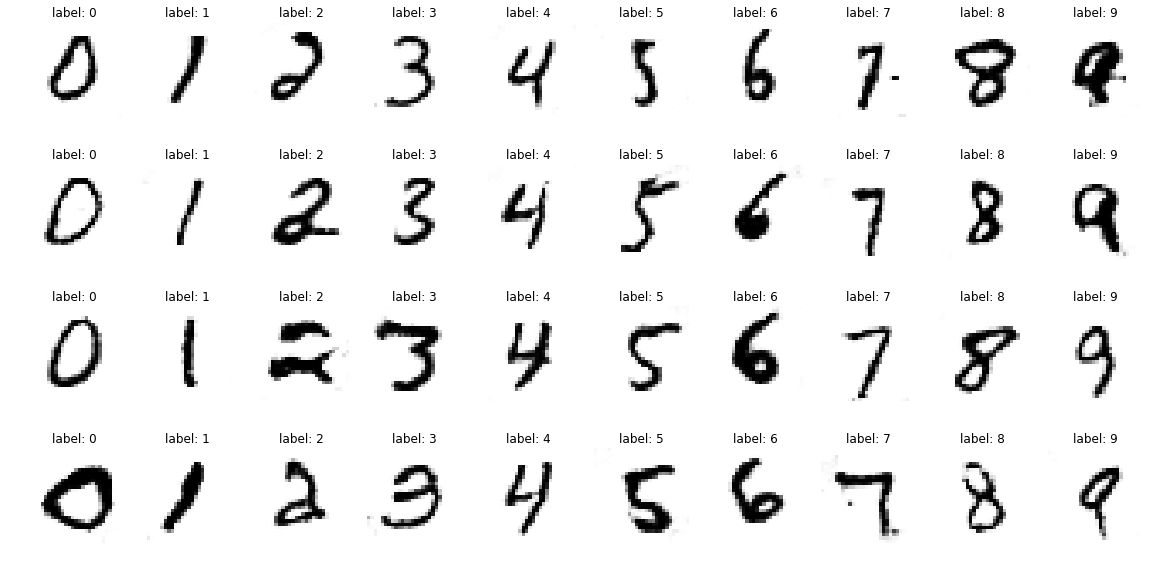

>41, 546/546, d_l=0.527, d_a=0.734 g=0.906
>42, 546/546, d_l=0.679, d_a=0.555 g=1.185
>43, 546/546, d_l=0.543, d_a=0.742 g=0.994
>44, 546/546, d_l=0.548, d_a=0.680 g=0.747
>45, 546/546, d_l=0.542, d_a=0.766 g=0.982
>46, 546/546, d_l=0.545, d_a=0.766 g=1.079
>47, 546/546, d_l=0.629, d_a=0.688 g=0.932
>48, 546/546, d_l=0.629, d_a=0.656 g=0.928
>49, 546/546, d_l=0.547, d_a=0.664 g=1.231
>50, 546/546, d_l=0.602, d_a=0.609 g=0.880


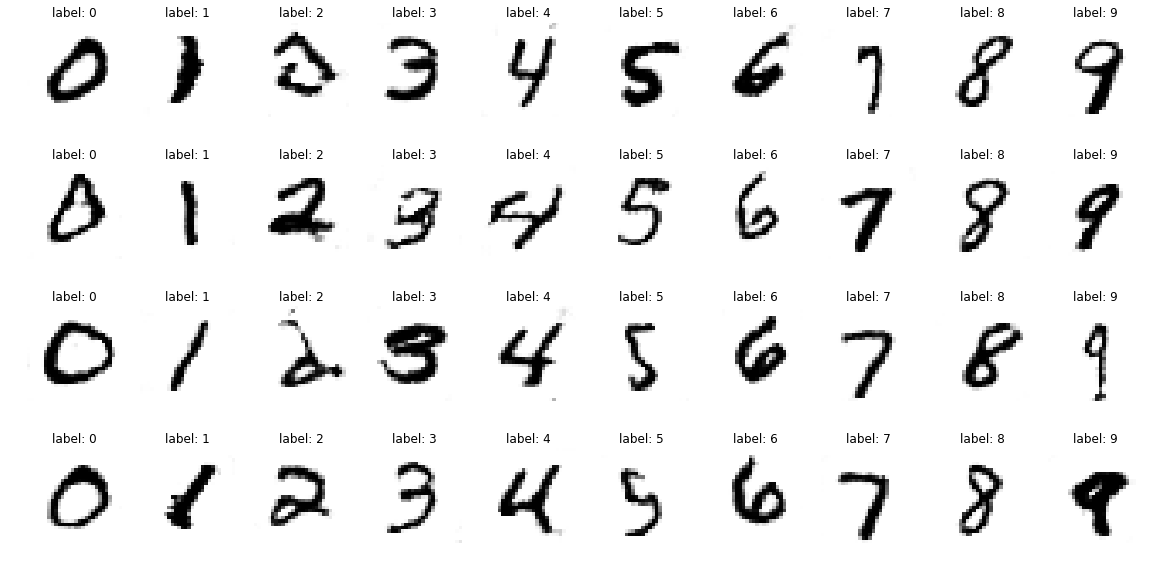

>51, 546/546, d_l=0.471, d_a=0.805 g=0.927
>52, 546/546, d_l=0.588, d_a=0.672 g=1.157
>53, 546/546, d_l=0.478, d_a=0.773 g=1.055
>54, 546/546, d_l=0.570, d_a=0.703 g=1.096
>55, 546/546, d_l=0.571, d_a=0.711 g=1.186
>56, 546/546, d_l=0.567, d_a=0.750 g=0.873
>57, 546/546, d_l=0.574, d_a=0.727 g=0.939
>58, 546/546, d_l=0.543, d_a=0.734 g=1.016
>59, 546/546, d_l=0.611, d_a=0.680 g=0.805
>60, 546/546, d_l=0.542, d_a=0.727 g=1.067


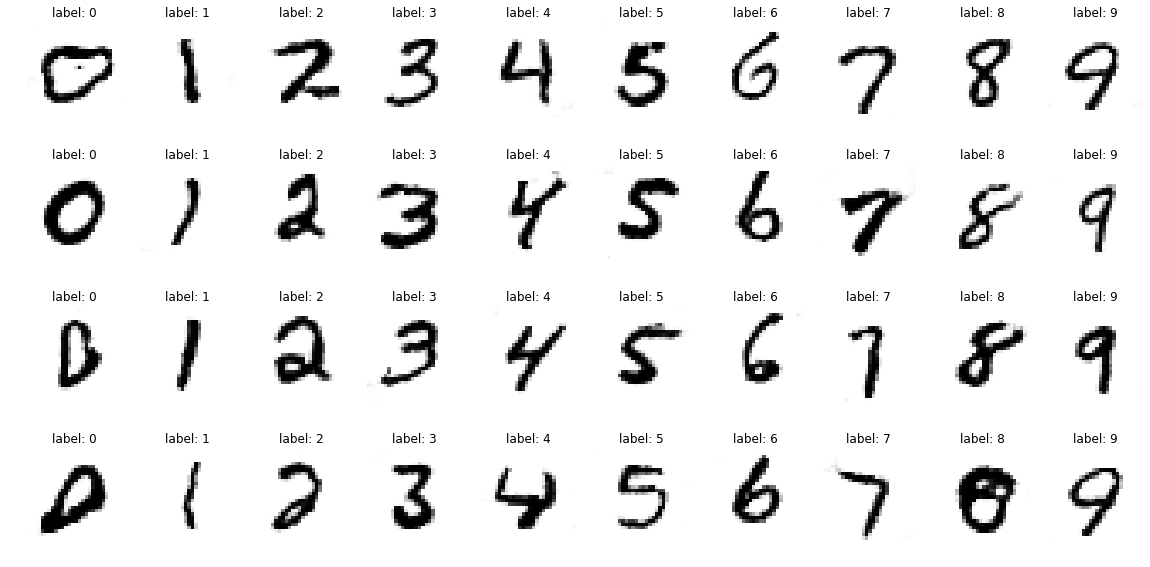

>61, 546/546, d_l=0.519, d_a=0.750 g=0.966
>62, 546/546, d_l=0.711, d_a=0.586 g=0.839
>63, 546/546, d_l=0.590, d_a=0.703 g=0.961
>64, 546/546, d_l=0.636, d_a=0.672 g=1.167
>65, 546/546, d_l=0.536, d_a=0.734 g=1.076
>66, 546/546, d_l=0.571, d_a=0.680 g=1.038
>67, 546/546, d_l=0.646, d_a=0.602 g=0.694
>68, 546/546, d_l=0.640, d_a=0.664 g=1.051
>69, 546/546, d_l=0.609, d_a=0.648 g=1.148
>70, 546/546, d_l=0.589, d_a=0.664 g=1.165


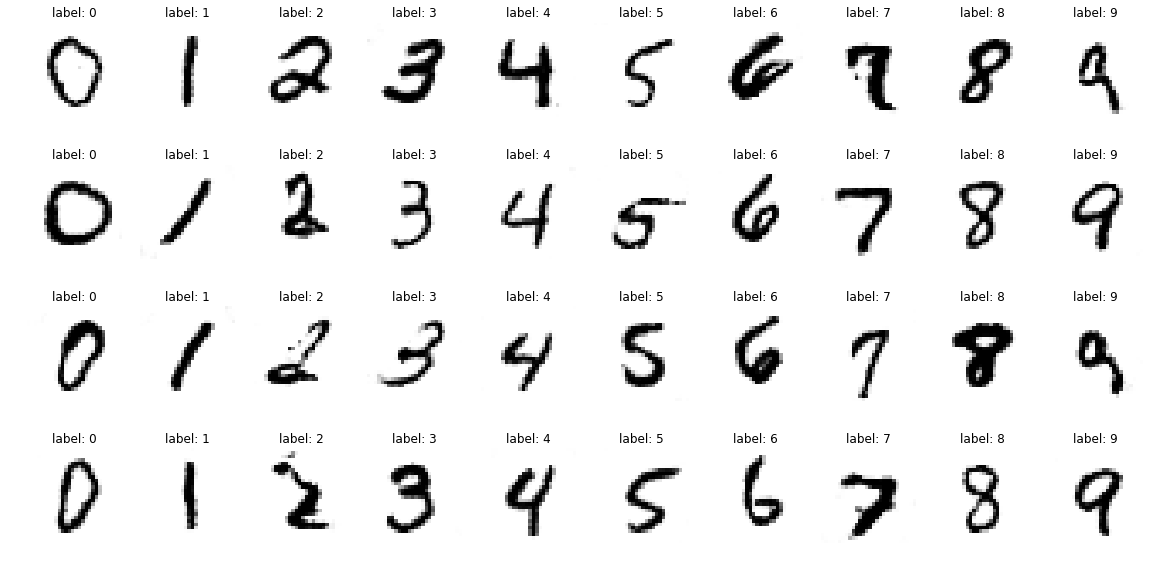

>71, 546/546, d_l=0.543, d_a=0.711 g=1.050
>72, 546/546, d_l=0.523, d_a=0.766 g=1.414
>73, 546/546, d_l=0.634, d_a=0.609 g=0.899
>74, 546/546, d_l=0.534, d_a=0.773 g=1.020
>75, 546/546, d_l=0.617, d_a=0.617 g=1.166
>76, 546/546, d_l=0.541, d_a=0.719 g=1.104
>77, 546/546, d_l=0.552, d_a=0.695 g=1.088
>78, 546/546, d_l=0.658, d_a=0.523 g=0.695
>79, 546/546, d_l=0.633, d_a=0.617 g=0.941
>80, 546/546, d_l=0.562, d_a=0.703 g=0.937


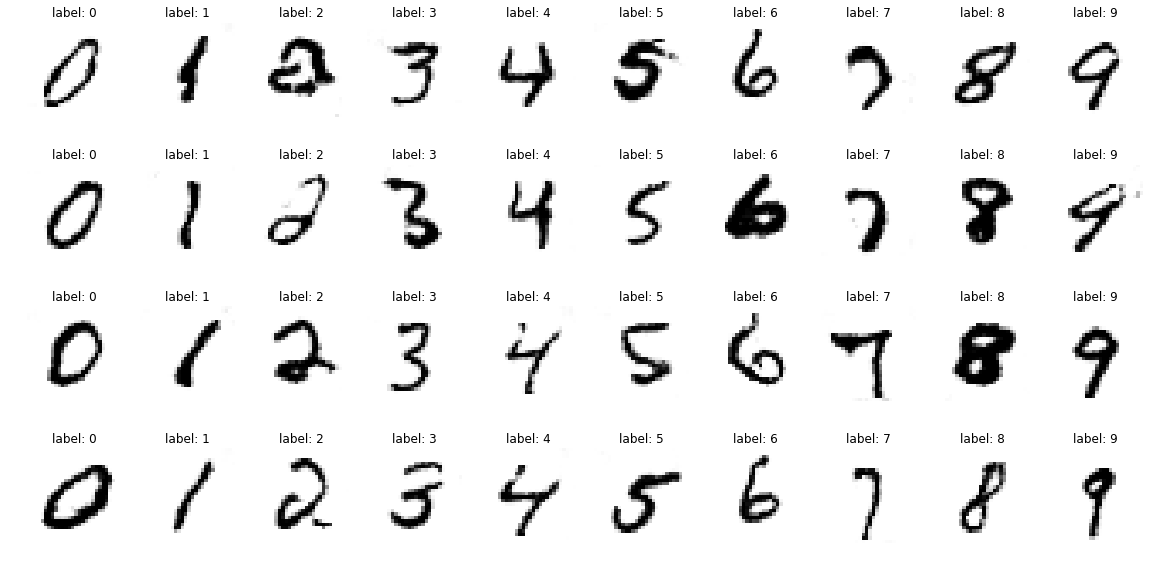

>81, 546/546, d_l=0.642, d_a=0.641 g=0.737
>82, 546/546, d_l=0.598, d_a=0.648 g=0.981
>83, 546/546, d_l=0.586, d_a=0.648 g=0.848
>84, 546/546, d_l=0.568, d_a=0.734 g=1.213
>85, 546/546, d_l=0.573, d_a=0.727 g=0.845
>86, 546/546, d_l=0.669, d_a=0.555 g=0.980
>87, 546/546, d_l=0.625, d_a=0.609 g=0.672
>88, 546/546, d_l=0.624, d_a=0.664 g=1.294
>89, 546/546, d_l=0.663, d_a=0.586 g=0.743
>90, 546/546, d_l=0.609, d_a=0.672 g=0.947


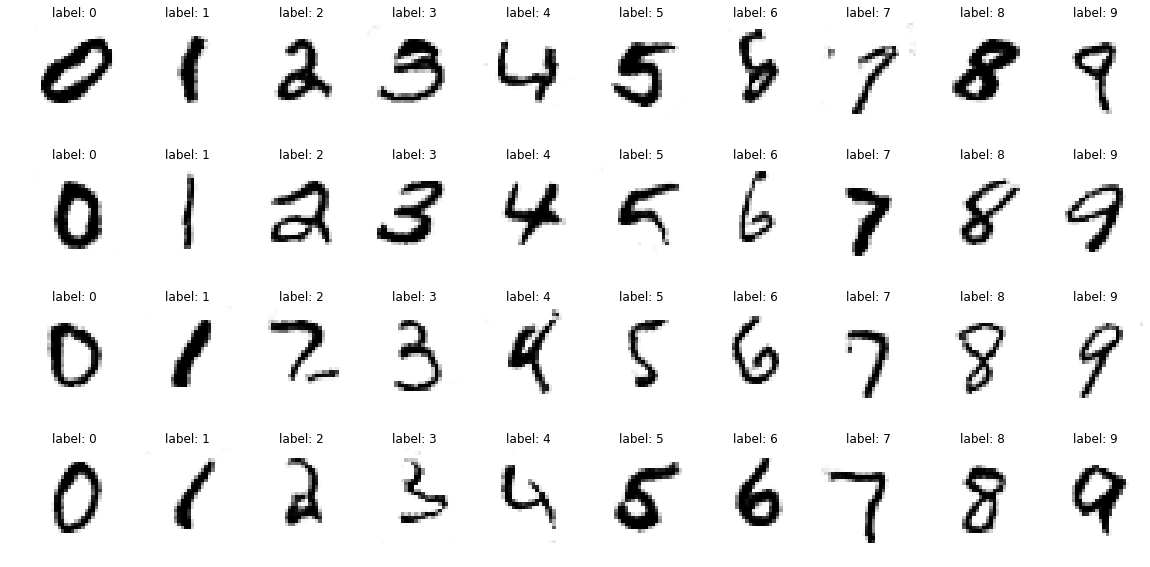

>91, 546/546, d_l=0.550, d_a=0.656 g=0.758
>92, 546/546, d_l=0.595, d_a=0.688 g=0.756
>93, 546/546, d_l=0.550, d_a=0.680 g=0.812
>94, 546/546, d_l=0.628, d_a=0.625 g=0.932
>95, 546/546, d_l=0.622, d_a=0.672 g=0.592
>96, 546/546, d_l=0.618, d_a=0.633 g=0.974
>97, 546/546, d_l=0.600, d_a=0.680 g=0.978
>98, 546/546, d_l=0.590, d_a=0.648 g=0.750
>99, 546/546, d_l=0.627, d_a=0.602 g=1.218
>100, 546/546, d_l=0.606, d_a=0.711 g=0.874


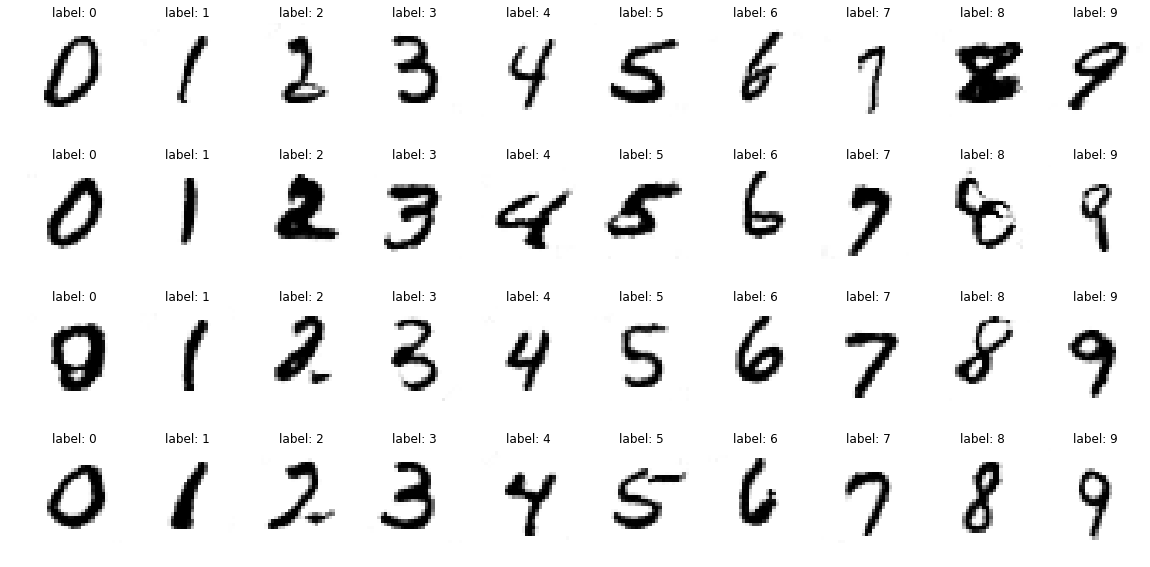

In [30]:
latent_dim = 100
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
dataset = load_real_data(mnist)
train(generator, discriminator, gan_model, dataset, hlatent_dim)
# Save the generator model
gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [0]:
cp *.h5 "gdrive/My Drive/MLCourseFF"
